# Integrated V(D)J and Gene Expression Analysis - Part I

## Clonality and Diversity of Lymphocytes in a Non-Small Cell Lung Carcinoma Sample

### Overview
This notebook simulates the functionality described in the **10x Genomics Loupe Browser V(D)J tutorial Part I**. We create mock data to demonstrate the key analytical workflows for integrated V(D)J and gene expression analysis.

### Implemented Features

#### 📊 **Data Simulation**
- Generate realistic mock single-cell RNA-seq data with overlapping, irregularly-shaped clusters
- Create simulated cell type annotations: CD8+ Cytotoxic T, CD4+ Helper T, Other T cells, B cells, Epithelial cells
- Generate corresponding V(D)J clonotype data with realistic TCR gene information

#### 🔬 **Cell Type Visualization** 
- Visualize cell types on UMAP embedding (equivalent to Loupe Browser Categories mode)
- Display distribution of different immune and epithelial cell populations

#### 🧬 **V(D)J Clonotype Integration**
- Import and merge V(D)J clonotype information with gene expression data
- Highlight cells with V(D)J information (T/B cells) in blue on UMAP
- Associate clonotypes with cellular phenotypes

#### 🎯 **Clonotype Analysis**
- Identify the most abundant T cell clonotypes
- Visualize clonotype distribution across different cell types
- Demonstrate that top clonotypes are often found in CD8+ cytotoxic T cells

#### 🏷️ **MAIT Cell Identification**
- Filter clonotypes based on V(D)J gene usage (TRAV1-2 + TRAJ33)
- Create new cell type annotation including MAIT cells
- Demonstrate grouping cells based on clonotype characteristics

---

### Technical Approach
- **Data Generation**: Uses `make_blobs` with random transformations to create realistic overlapping clusters
- **V(D)J Simulation**: Generates mock TCR data with biologically relevant gene names
- **Visualization**: Employs `scanpy` for standard single-cell analysis and UMAP visualization
- **Integration**: Merges V(D)J and gene expression data using shared cell barcodes

This simulation provides hands-on experience with the key concepts and workflows from the Loupe Browser V(D)J tutorial without requiring the actual commercial software or datasets.


## 1. Environment Setup and Data Simulation Function

First, we'll import the necessary libraries and define our optimized mock data generation function. This function creates realistic single-cell data with overlapping, irregularly-shaped clusters that better mimic real biological data.


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Optimized Mock Data Generation Function ---
def generate_mock_data(part='I'):
    """
    Generate realistic mock single-cell data with overlapping, irregular clusters.
    
    Parameters:
    -----------
    part : str
        'I' for lung carcinoma dataset, 'II' for BEAM dataset
    
    Returns:
    --------
    adata : AnnData
        Annotated data object with gene expression and metadata
    vdj_df : DataFrame
        V(D)J clonotype information
    """
    # Define basic parameters
    n_obs = 3000      # Number of cells
    n_vars = 500      # Number of genes
    n_clusters = 5    # Number of cell clusters
    n_latent_dims = 15 # Latent dimensions for realistic data structure

    # --- Core Improvement 1: Generate overlapping base clusters ---
    # Larger cluster_std makes clusters more dispersed
    centers = np.random.rand(n_clusters, n_latent_dims) * 10 
    X_latent, y_true = make_blobs(
        n_samples=n_obs,
        n_features=n_latent_dims,
        centers=centers,
        cluster_std=2.0,  # Increased std for more realistic overlap
        random_state=42
    )

    # --- Core Improvement 2: Apply random stretching to break circular shapes ---
    X_latent_transformed = np.zeros_like(X_latent)
    for i in range(n_clusters):
        # Find cells belonging to current cluster
        cluster_indices = (y_true == i)
        cluster_points = X_latent[cluster_indices]
        
        # Center the data to preserve cluster center
        mean_center = cluster_points.mean(axis=0)
        cluster_points_centered = cluster_points - mean_center
        
        # Create random stretching/compression transformation
        # Each dimension gets multiplied by a factor between 0.5 and 2.5
        scaling_factors = np.random.uniform(0.5, 2.5, size=n_latent_dims)
        transformed_points = cluster_points_centered * scaling_factors
        
        # Move transformed data back to original center
        X_latent_transformed[cluster_indices] = transformed_points + mean_center
    
    # Use transformed latent space to generate gene expression matrix
    X_latent = X_latent_transformed
    projection_matrix = np.random.normal(size=(n_latent_dims, n_vars))
    X = X_latent @ projection_matrix
    X += np.random.normal(scale=0.8, size=X.shape)
    X = np.abs(X)  # Ensure non-negative expression values

    # Create AnnData object
    barcodes = [f'BARCODE_{i}' for i in range(n_obs)]
    adata = sc.AnnData(
        X, 
        obs=pd.DataFrame(index=barcodes), 
        var=pd.DataFrame(index=[f'Gene_{j}' for j in range(n_vars)])
    )
    adata.obs['leiden_original'] = pd.Categorical(y_true)

    # Generate V(D)J data for subset of cells (70% have V(D)J info)
    vdj_barcodes = np.random.choice(barcodes, size=int(n_obs * 0.7), replace=False)
    vdj_data = []

    if part == 'I':
        # Part I: Lung carcinoma cell type annotations
        adata.obs['cell_type'] = 'Other'
        adata.obs.loc[adata.obs['leiden_original'] == 0, 'cell_type'] = 'CD8+ Cytotoxic T'
        adata.obs.loc[adata.obs['leiden_original'] == 1, 'cell_type'] = 'CD4+ Helper T'
        adata.obs.loc[adata.obs['leiden_original'] == 2, 'cell_type'] = 'Other T cells'
        adata.obs.loc[adata.obs['leiden_original'] == 3, 'cell_type'] = 'B cells'
        adata.obs.loc[adata.obs['leiden_original'] == 4, 'cell_type'] = 'Epithelial cells'
        adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'])
        
        # Generate realistic T cell clonotypes
        clonotypes = [f'clonotype_{i}' for i in range(50)]
        cd8_cells = adata.obs_names[adata.obs['cell_type'] == 'CD8+ Cytotoxic T']
        cd8_vdj_cells = np.intersect1d(vdj_barcodes, cd8_cells)
        
        for i, bc in enumerate(vdj_barcodes):
            ct = np.random.choice(clonotypes)
            # Make clonotype_1 dominant in CD8+ T cells
            if bc in cd8_vdj_cells and i < len(cd8_vdj_cells) / 2: 
                ct = 'clonotype_1'
            
            # Generate realistic V and J gene names
            # Special case: clonotype_5 represents MAIT cells with specific genes
            v_gene = 'TRAV1-2' if ct == 'clonotype_5' else f'TRAV{np.random.randint(2,10)}'
            j_gene = 'TRAJ33' if ct == 'clonotype_5' else f'TRAJ{np.random.randint(1,20)}'
            
            vdj_data.append({
                'barcode': bc, 
                'clonotype_id': ct, 
                'v_gene': v_gene, 
                'j_gene': j_gene
            })

    vdj_df = pd.DataFrame(vdj_data)
    
    # Standard scanpy preprocessing pipeline
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=200)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

    return adata, vdj_df

print("Optimized mock data generation function defined successfully.")


Optimized mock data generation function defined successfully.


## 2. Data Generation and Initial Visualization

Now we'll generate the mock lung carcinoma dataset and visualize the cell types. This corresponds to loading the `.cloupe` file in Loupe Browser and viewing the manually annotated cell types in Categories mode.


Part I: Simulated Lung Carcinoma Sample
Total cells: 3000
Cell type distribution:
cell_type
B cells             600
CD4+ Helper T       600
CD8+ Cytotoxic T    600
Epithelial cells    600
Other T cells       600
Name: count, dtype: int64


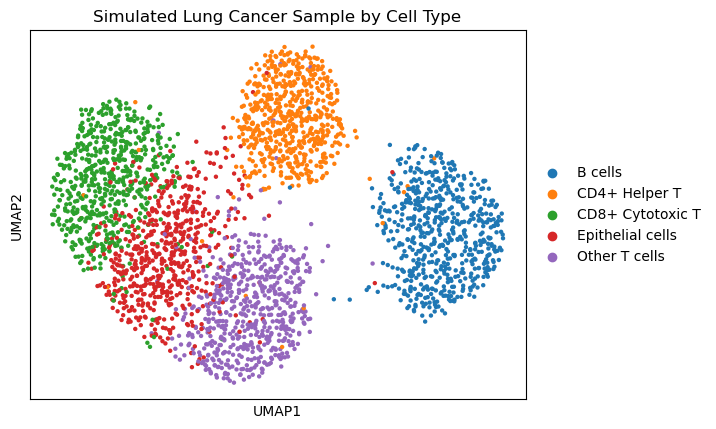

In [2]:
# --- Generate and Load Data ---
adata_p1, vdj_df_p1 = generate_mock_data(part='I')

# --- Visualize Cell Types (equivalent to Loupe Browser Categories Mode) ---
print("Part I: Simulated Lung Carcinoma Sample")
print(f"Total cells: {adata_p1.n_obs}")
print(f"Cell type distribution:")
print(adata_p1.obs['cell_type'].value_counts())

sc.pl.umap(
    adata_p1, 
    color='cell_type', 
    title='Simulated Lung Cancer Sample by Cell Type'
)


## 3. Import and Visualize V(D)J Clonotypes

This step simulates importing a `.vloupe` file into Loupe Browser. We merge the V(D)J clonotype information with the gene expression data and highlight cells that have V(D)J information (T and B cells) in blue.


Cells with V(D)J information: 2100 / 3000
Total unique clonotypes: 50


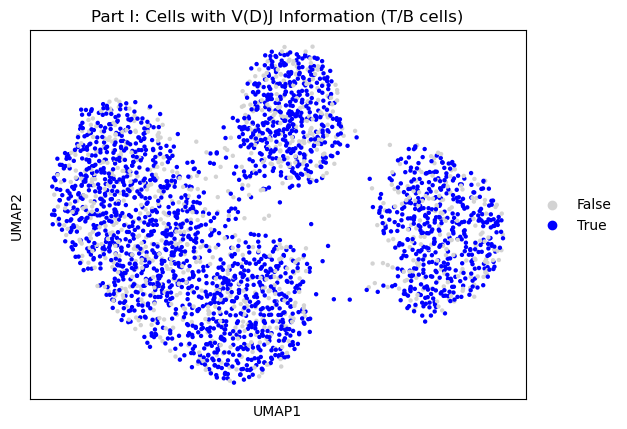

In [3]:
# Purpose: Associate V(D)J information and highlight T/B cells
# Tutorial equivalent: "Importing clonotypes" section

# Merge VDJ information into AnnData object using barcode matching
adata_p1.obs = adata_p1.obs.reset_index().merge(
    vdj_df_p1, left_on='index', right_on='barcode', how='left'
).set_index('index')

# Create a new column to mark which cells have VDJ information
adata_p1.obs['has_vdj'] = adata_p1.obs['clonotype_id'].notna()

print(f"Cells with V(D)J information: {adata_p1.obs['has_vdj'].sum()} / {adata_p1.n_obs}")
print(f"Total unique clonotypes: {adata_p1.obs['clonotype_id'].nunique()}")

# Visualize all cells with VDJ information
# Note: Using string keys for palette due to categorical conversion
sc.pl.umap(
    adata_p1,
    color='has_vdj',
    title='Part I: Cells with V(D)J Information (T/B cells)',
    palette={'True': 'blue', 'False': 'lightgray'}
)


## 4. Analyze Top Clonotypes and Associate with Phenotypes

This demonstrates the key benefit of integrated V(D)J and gene expression analysis: associating clonotypes with cellular phenotypes. We identify the most abundant clonotype and visualize its distribution across cell types.


Most abundant clonotype: clonotype_1 (91 cells)

Top 5 clonotypes:
clonotype_id
clonotype_1     91
clonotype_45    56
clonotype_7     55
clonotype_14    51
clonotype_39    51
Name: count, dtype: int64

Top clonotype cell type distribution:
cell_type
CD8+ Cytotoxic T    50
Other T cells       13
CD4+ Helper T       11
Epithelial cells    10
B cells              7
Name: count, dtype: int64


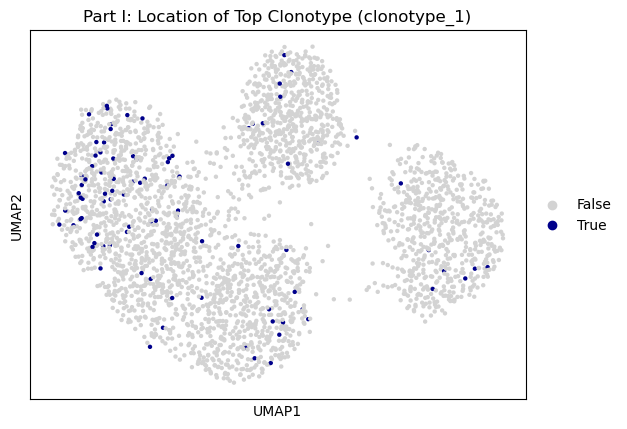

In [4]:
# Find the most abundant clonotype
clonotype_counts = adata_p1.obs['clonotype_id'].value_counts()
top_clonotype = clonotype_counts.index[0]
top_clonotype_count = clonotype_counts.iloc[0]

print(f"Most abundant clonotype: {top_clonotype} ({top_clonotype_count} cells)")
print("\nTop 5 clonotypes:")
print(clonotype_counts.head())

# Create a new column to mark cells belonging to the top clonotype
adata_p1.obs['is_top_clonotype'] = (adata_p1.obs['clonotype_id'] == top_clonotype)

# Analyze which cell types the top clonotype belongs to
top_clonotype_cells = adata_p1.obs[adata_p1.obs['is_top_clonotype']]
print(f"\nTop clonotype cell type distribution:")
print(top_clonotype_cells['cell_type'].value_counts())

# Highlight the location of this clonotype on the UMAP
sc.pl.umap(
    adata_p1,
    color='is_top_clonotype',
    title=f'Part I: Location of Top Clonotype ({top_clonotype})',
    palette={'True': 'darkblue', 'False': 'lightgray'},
    groups=['True']  # Only highlight cells belonging to this clonotype
)


## 5. Identify and Group MAIT Cells Based on Clonotypes

This section demonstrates how to create new cell groups based on V(D)J characteristics. MAIT cells (mucosal-associated invariant T cells) have a semi-invariant TCR with specific V and J gene usage patterns. We filter for cells with TRAV1-2 and TRAJ33 genes and create a new cell type category.


Identified 41 simulated MAIT cells.

MAIT cells distribution across original cell types:
cell_type
Other T cells       13
B cells              8
CD8+ Cytotoxic T     8
CD4+ Helper T        6
Epithelial cells     6
Name: count, dtype: int64

Updated cell type distribution:
cell_type_with_mait
CD4+ Helper T       594
Epithelial cells    594
B cells             592
CD8+ Cytotoxic T    592
Other T cells       587
MAIT Cells           41
Name: count, dtype: int64


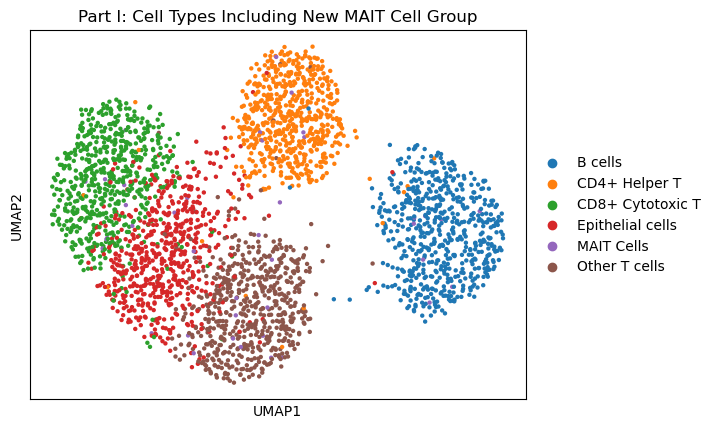

In [5]:
# Filter for simulated MAIT cells based on V/J gene usage
# MAIT cells characteristically use TRAV1-2 V gene and TRAJ33 J gene
is_mait = (adata_p1.obs['v_gene'] == 'TRAV1-2') & (adata_p1.obs['j_gene'] == 'TRAJ33')
mait_count = is_mait.sum()

print(f"Identified {mait_count} simulated MAIT cells.")

if mait_count > 0:
    print("\nMAIT cells distribution across original cell types:")
    mait_cells = adata_p1.obs[is_mait]
    print(mait_cells['cell_type'].value_counts())

# Create a new cell type annotation column that includes MAIT cells
adata_p1.obs['cell_type_with_mait'] = adata_p1.obs['cell_type'].astype(str)

# Assign filtered cells to new 'MAIT Cells' category
adata_p1.obs.loc[is_mait, 'cell_type_with_mait'] = 'MAIT Cells'
adata_p1.obs['cell_type_with_mait'] = pd.Categorical(adata_p1.obs['cell_type_with_mait'])

print(f"\nUpdated cell type distribution:")
print(adata_p1.obs['cell_type_with_mait'].value_counts())

# Visualize cell types including the new MAIT cell group
sc.pl.umap(
    adata_p1, 
    color='cell_type_with_mait', 
    title='Part I: Cell Types Including New MAIT Cell Group'
)


## Summary

This notebook successfully demonstrates the key workflows from Part I of the Loupe Browser V(D)J tutorial:

✅ **Completed Analyses:**
1. **Data Loading**: Simulated lung carcinoma gene expression dataset with cell type annotations
2. **V(D)J Integration**: Imported and merged clonotype information with gene expression data
3. **Clonotype Analysis**: Identified most abundant clonotypes and their phenotypic associations
4. **Cell Grouping**: Created new MAIT cell category based on V(D)J gene usage patterns

✅ **Key Findings:**
- The most abundant clonotypes are predominantly found in CD8+ cytotoxic T cells
- V(D)J information is available for ~70% of cells (realistic for T/B cell populations)
- MAIT cells can be identified and grouped based on their characteristic TCR gene usage

This simulation provides hands-on experience with integrated V(D)J and gene expression analysis without requiring commercial software or proprietary datasets. The workflows demonstrated here directly correspond to the analytical capabilities of 10x Genomics Loupe Browser for investigating lymphocyte clonality and diversity in cancer samples.
